# HSCT survival: Cox proportional hazards model

## Notebook set-up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.duration import hazard_regression
from sklearn.model_selection import train_test_split

import configuration as config

# Data files
training_features_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_training_labels_df.parquet'
raw_training_features_file=f'{config.DATA_PATH}/raw/train.csv'

## 1. Load data

Features: (28800, 178)
Labels: (28800, 2)


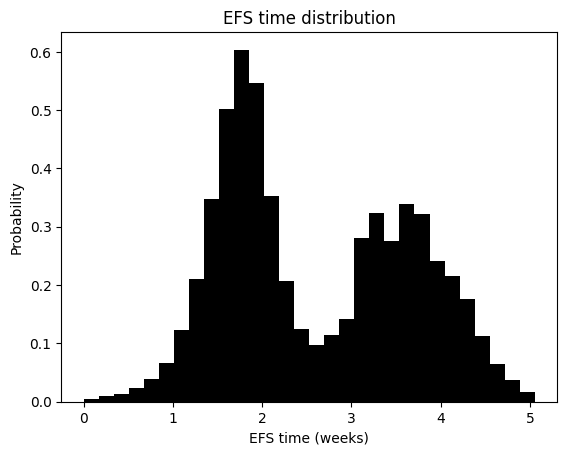

In [2]:
# Load the datasets
features_df=pd.read_parquet(training_features_df_file)
raw_features_df=pd.read_csv(raw_training_features_file)
labels_df=raw_features_df[['efs', 'efs_time']].copy()

# Log transform efs_time
labels_df['efs_time']=abs(np.log(labels_df['efs_time']))

# Remove id column from training features
features_df.drop('ID', axis=1, inplace=True)

print(f'Features: {features_df.shape}')
print(f'Labels: {labels_df.shape}')

plt.title('EFS time distribution')
plt.hist(labels_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time (weeks)')
plt.ylabel('Probability')
plt.show()

## 2. Train-test split

In [3]:
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features_df, 
    labels_df,
    test_size=0.33,
    random_state=315
)

training_features_df=pd.DataFrame(training_features, columns=features_df.columns)
testing_features_df=pd.DataFrame(testing_features, columns=features_df.columns)

training_labels_df=pd.DataFrame(training_labels, columns=labels_df.columns)
testing_labels_df=pd.DataFrame(testing_labels, columns=labels_df.columns)

## 3. Cox proportional hazards model

In [4]:
cph_model=hazard_regression.PHReg(
    training_labels_df['efs_time'],
    training_features_df,
    status=training_labels_df['efs']
)

result=cph_model.fit()

print(result.summary())

                                                  Results: PHReg
Model:                                     PH Reg                         Sample size:                       19296
Dependent variable:                        efs_time                       Num. events:                       10420
Ties:                                      Breslow                                                                
------------------------------------------------------------------------------------------------------------------
                                                             log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
------------------------------------------------------------------------------------------------------------------
hla_match_c_high                                            -0.0438    0.0322 0.9571  -1.3593 0.1741 0.8986 1.0195
hla_high_res_8                                               0.1373    0.1315 1.1471   1.0439 0.2965 0.8865 1.4843
hla_low_res_6  

## 4. Test set predictions

### 4.1. Survival curve forecasts

In [5]:
# Note: looped point predictions take about 20 seconds per
# patient for 160 time points, and it does run on all cores

testing_survival_curves=[]

# for _, row in testing_features_df.iterrows():
for i in range(5):

    predictions=[]

    for j in range(1,160):

        prediction=result.predict(
            exog=testing_features_df.iloc[i],
            endog=np.array([[j]]).astype(int),
            pred_type='surv'
        )

        predictions.append(prediction.predicted_values)

    testing_survival_curves.append(predictions)

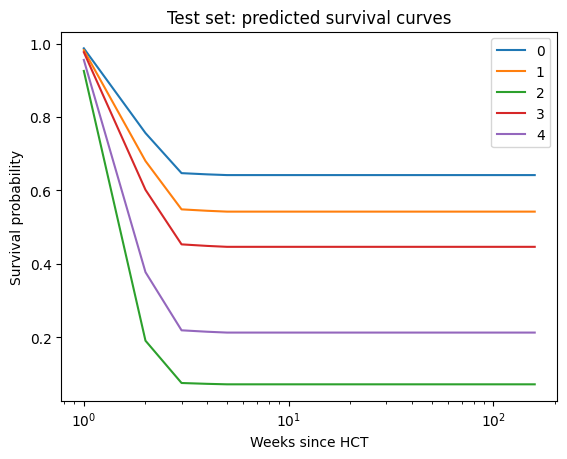

In [6]:
plt.title('Test set: predicted survival curves')

for i, survival_curve in enumerate(testing_survival_curves):
    plt.plot(list(range(1,160)), survival_curve, label=i)

plt.xlabel('Weeks since HCT')
plt.ylabel('Survival probability')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

### 4.2. Cumulative hazard forecasts

In [7]:
# Note: looped point predictions take about 20 seconds per
# patient for 160 time points, and it does run on all cores

testing_survival_curves=[]

# for _, row in testing_features_df.iterrows():
for i in range(5):

    predictions=[]

    for j in range(1,160):

        prediction=result.predict(
            exog=testing_features_df.iloc[i],
            endog=np.array([[j]]),
            pred_type='cumhaz'
        )

        predictions.append(prediction.predicted_values)

    testing_survival_curves.append(predictions)

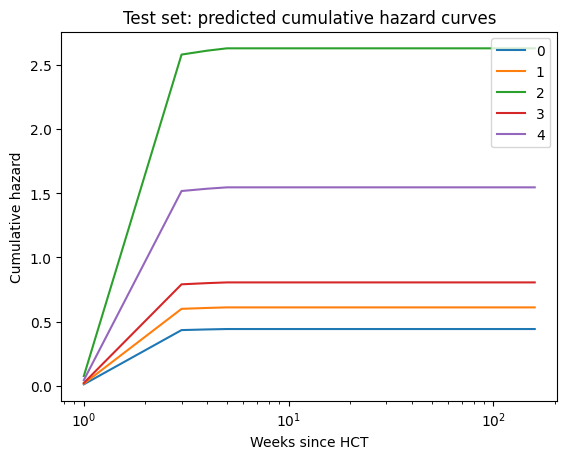

In [8]:
plt.title('Test set: predicted cumulative hazard curves')

for i, survival_curve in enumerate(testing_survival_curves):
    plt.plot(list(range(1,160)), survival_curve, label=i)

plt.xlabel('Weeks since HCT')
plt.ylabel('Cumulative hazard')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

### 4.2. Survival function forecasts: 20 weeks

In [9]:
survival_function_values=[]
sample_testing_features_df=testing_features.iloc[:1000]

for _, row in sample_testing_features_df.iterrows():

    prediction=result.predict(
        exog=row,
        endog=np.array([[20]]),
        pred_type='surv'
    )

    survival_function_values.append(prediction.predicted_values)

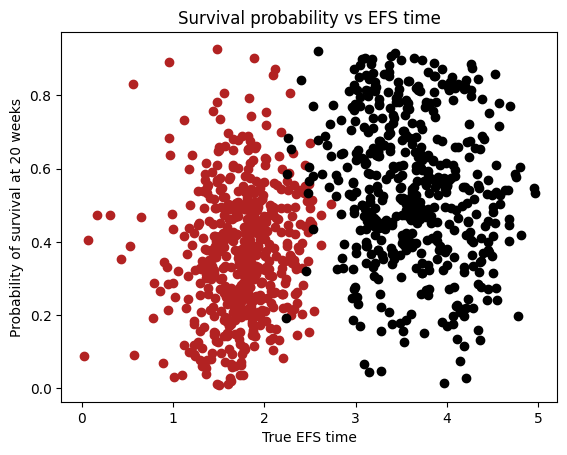

In [10]:
sample_testing_labels_df=testing_labels_df.iloc[:1000].copy()
sample_testing_labels_df['Survival probability']=survival_function_values

efs_positive_df=sample_testing_labels_df[sample_testing_labels_df['efs'] == 1]
efs_negative_df=sample_testing_labels_df[sample_testing_labels_df['efs'] == 0]

plt.title('Survival probability vs EFS time')
plt.scatter(efs_positive_df['efs_time'], efs_positive_df['Survival probability'], color='firebrick', label='EFS 1')
plt.scatter(efs_negative_df['efs_time'], efs_negative_df['Survival probability'], color='black', label='EFS 0')
plt.xlabel('True EFS time')
plt.ylabel('Probability of survival at 20 weeks')
plt.show()

## 5. Survival function estimate at EFS time

In [11]:
survival_function_values=[]

for i in range(1000):

    feature_row=training_features_df.iloc[i]
    label_row=training_labels_df.iloc[i]

    prediction=result.predict(
        exog=feature_row,
        endog=np.array([[label_row['efs_time']]]),
        pred_type='surv'
    )

    survival_function_values.extend(prediction.predicted_values)

survival_function_estimate=training_labels_df.iloc[:1000].copy()
survival_function_estimate['survival_function']=survival_function_values

efs_negative=survival_function_estimate[survival_function_estimate['efs'] == 0]
efs_positive=survival_function_estimate[survival_function_estimate['efs'] == 1]

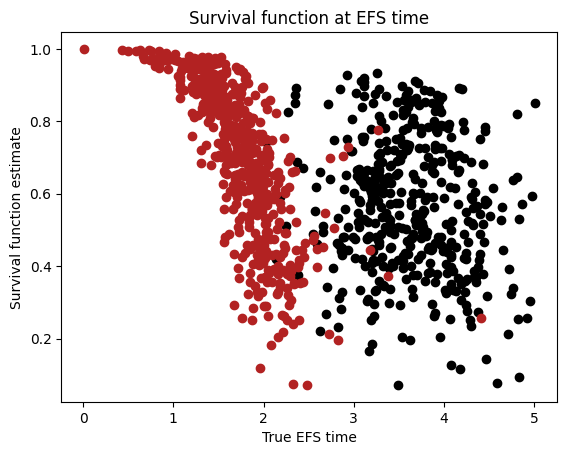

In [12]:
plt.title('Survival function at EFS time')
plt.scatter(efs_negative['efs_time'], efs_negative['survival_function'], color='black', label='EFS 0')
plt.scatter(efs_positive['efs_time'], efs_positive['survival_function'], color='firebrick', label='EFS 1')
plt.xlabel('True EFS time')
plt.ylabel('Survival function estimate')
plt.show()